**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
import math
from sympy import symbols, lambdify
from sympy.utilities.lambdify import lambdify


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# a. Setting parameters 
L = sm.symbols('L') 
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
tau = sm.symbols('tau')
w_t = sm.symbols('w_t')
V = sm.symbols('V')

# b. Writing up profits 
consumption = kappa+w_t*L

# c. Inserting consumption 
Utility = sm.ln(consumption**alpha*G**(1-alpha))-nu*(L**2/2)

# d. Taking first order conditions wrt. L
FOC = sm.diff(Utility, L)

# e. Isolating for L
sol = sm.solve(FOC, L)

sol_L = sm.Eq(L, sol[1])
sol_L

Eq(L, (-kappa*nu + sqrt(nu*(4*alpha*w_t**2 + kappa**2*nu)))/(2*nu*w_t))

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

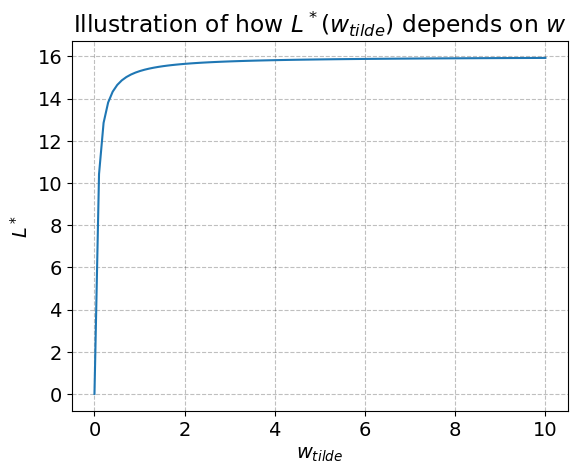

In [3]:
# Creating a list of the parameters
parameters = {
kappa: 1.0,
alpha: 0.5,
tau: 0.3,
nu: 1/(2*(16**2)),
w: 1,
w_t: (1-0.3)*1
}

# To be able to illustrate how L^* depends on w we need to substitute the expression for w^tilde into the expression for L^* as found in Q1.1
sol_L = sol_L.subs(w_t, (1-tau)*w)

# Defining the interval for the w values (setting it to show w up to 10 in the graph since this is where it gets more stable)
w_values = np.linspace(1e-8, 10, 100)

# Substituting the parameters defined in the dictionary above into the expression of L^* and creating a new dictionary and adding w
L_v = sol_L.subs({**parameters, w: w})

# Evaluating the expression for L^*
L_va = L_v.rhs.evalf()

# Turning L it into a python function depending on w
L_f = lambdify(w,L_va)

# We create a loop such that we obtain different values of L^* depending on the value of w
L_values = [L_f(w_value) for w_value in w_values]

# Creating the plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_values,L_values)
ax.set_title('Illustration of how $L^*(w_{tilde})$ depends on $w$')
ax.set_xlabel('$w_{tilde}$')
ax.set_ylabel('$L^*$');


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in true_divide
  return 256.0*(0.0625*sqrt((1.0 - tau)**2 + 0.0009765625) - 0.001953125)/(1.0 - tau)


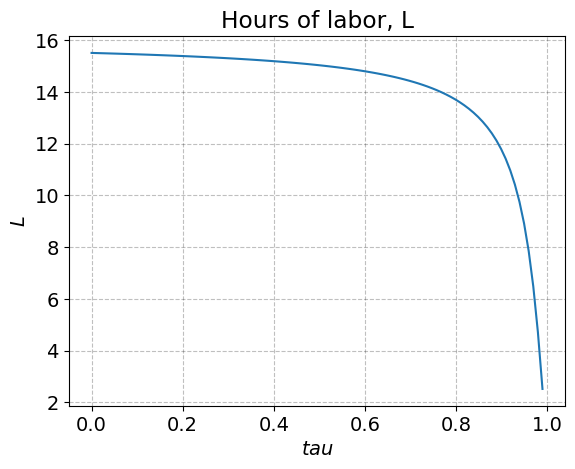

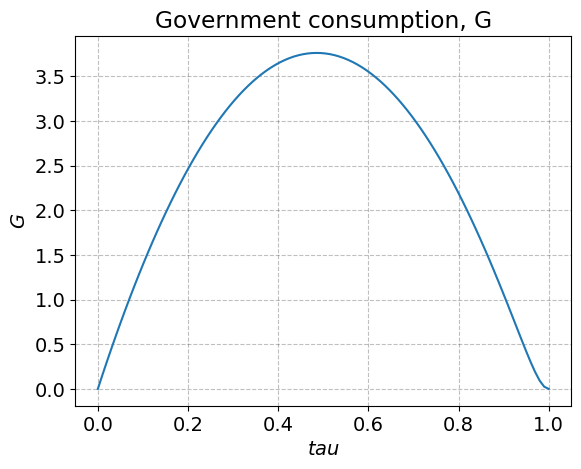

In [8]:
# Defining the range of tau values
tau_values = np.linspace(1e-8, 1, 100)

# Defining the utility function
Utility_new = sm.Eq(V, sm.log((kappa + w_t*L)**alpha*G**(1-alpha))-nu*(L**2/2))

# Write up the three functions we need
L_function = sol_L.rhs
G_function = sm.Eq(G, tau*w*sol_L.rhs*((1-tau)*w))
V_function = Utility_new.subs(w_t, (1-tau)*w)

# Creating empty lists to store our results
L_new1 = []
G_new1 = []
V_new1 = []

# Inserting parameters
L_expr = L_function.subs({**parameters, tau: tau})
G_expr = G_function.subs({**parameters, tau: tau})
V_expr = V_function.subs({**parameters, tau: tau})
    
# Evaluating the result
L_new2 = L_expr.evalf()
G_new2 = G_expr.rhs.evalf()
V_new2 = V_expr.evalf()

# Converting the function into python functions
L_func1 = lambdify(tau, L_new2, modules='numpy')
G_func1 = lambdify(tau, G_new2, modules='numpy')
#V_func1 = lambdify(tau, V_new1, modules='math')

# Evaluating the expression to tau
L_values_new = L_func1(tau_values)
G_values_new = G_func1(tau_values)
#V_values_new = V_func1(tau_values)

# Plotting figures
fig1 = plt.figure()
ax = fig1.add_subplot(1,1,1)
ax.plot(tau_values, L_values_new)
ax.set_title('Hours of labor, L')
ax.set_xlabel('$tau$')
ax.set_ylabel('$L$');

fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(tau_values, G_values_new)
ax.set_title('Government consumption, G')
ax.set_xlabel('$tau$')
ax.set_ylabel('$G$');

#fig3 = plt.figure()
#ax = fig3.add_subplot(1,1,1)
#ax.plot(tau_values, V_values_new)
#ax.set_title('Government consumption, G')
#ax.set_xlabel('$tau$')
#ax.set_ylabel('$G$');

In [4]:
# Defining the range of tau values
tau_values = np.linspace(0.5, 1, 100)

# Defining the utility function
Utility_new = sm.Eq(V, sm.log((kappa + w_t*L)**alpha*G**(1-alpha))-nu*(L**2/2))

# Write up the three functions we need
L_function = sol_L.rhs
G_function = sm.Eq(G, tau*w*sol_L.rhs*((1-tau)*w))
V_function = Utility_new.subs(w_t, (1-tau)*w)

# Creating empty lists to store our results
L_new1 = []
G_new1 = []
V_new1 = []

# Inserting parameters
for tau_val in tau_values:
    L_expr = L_function.subs({**parameters, tau: tau_val})
    G_expr = G_function.subs({**parameters, tau: tau_val})
    V_expr = V_function.subs({**parameters, tau: tau_val})
    
    # Evaluating the result
    L_new2 = L_expr.evalf()
    G_new2 = G_expr.rhs.evalf()
    V_new2 = V_expr.evalf()

    # Appending
    L_new1.append(L_new2)
    G_new1.append(G_new2)
    V_new1.append(V_new2)

# Converting the function into python functions
L_func1 = lambdify(tau, L_new1, modules='numpy')
G_func1 = lambdify(tau, G_new1, modules='numpy')
V_func1 = lambdify(tau, V_new1, modules='math')

# Evaluating the expression to tau
L_values_new = L_func1(tau_values)
G_values_new = G_func1(tau_values)
V_values_new = V_func1(tau_values)

# Plotting figures
fig1 = plt.figure()
ax = fig1.add_subplot(1,1,1)
ax.plot(tau_values, L_values_new)
ax.set_title('Hours of labor, L')
ax.set_xlabel('$tau$')
ax.set_ylabel('$L$');

fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(tau_values, G_values_new)
ax.set_title('Government consumption, G')
ax.set_xlabel('$tau$')
ax.set_ylabel('$G$');

fig3 = plt.figure()
ax = fig3.add_subplot(1,1,1)
ax.plot(tau_values, V_values_new)
ax.set_title('Government consumption, G')
ax.set_xlabel('$tau$')
ax.set_ylabel('$G$');

NameError: name 'V' is not defined

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [ ]:
test = (-kappa + sm.sqrt(kappa**2 + 4 * alpha/nu * w_t**2)) / (2 * w_t)

# a. Defining government consumption
G4 = tau*w*test*((1-tau)*w)

# b. Inserting government consumption and consumption 
V4 = sm.log(consumption**alpha*G4**(1-alpha))-nu*(L**2/2)

# c. Finding FOC wrt. tau 
FOC4 = sm.diff(V4, tau)

# d. Solving the model for optimal tax rate
sol4 = sm.solve(FOC4, tau)
sol_tau = sm.Eq(tau, sol4[0])

print('The optimal tax rate is:')
display(sol_tau)


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [ ]:
# a. Setting new parameters 
sigma = sm.symbols('sigma') 
rho = sm.symbols('rho')

# a. Defining optimal tau 
tau_val = sol4[0]

# b. 
V5 = (((alpha*consumption**((sigma-1)/sigma)+(1-alpha)*G4**((sigma-1)/sigma))**(sigma/(sigma-1))**(1-rho))-1)/(1-rho)-nu

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [ ]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# a. Setting parameters 
l = sm.symbols('l') 
eta = sm.symbols('eta')
kappa = sm.symbols('kappa')
w = sm.symbols('w')

# b. Writing up profits 
profits = kappa*l**(1-eta)-w*l

# c. Taking first order conditions wrt. l 
foc = sm.diff(profits, l)

# d. Isolating for l_t
sol = sm.solve(sm.Eq(foc,0), l)
sol[0]

We have now shown that $l_t$ maximizes profits for $\kappa\in\left\{1.0 , 2.0\right\}$

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [ ]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [ ]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

We start of by drawing many random starting values. We set the seed to 2023 so we are able to replicate our results.

In [ ]:
# Step A: Drawing random x^k uniformly within chosen bounds
np.random.seed(2023)
K_warmup = 10
K = 1000

x0s = -600 + 1200*np.random.uniform(size=(K,2)) # drawing from -600 to +600
xs = np.empty((K,2))
fs = np.empty(K)

In [ ]:
# Step B: Showing k
print(f'min(x0s) = {np.min(x0s):.2f}, max(x0s) = {np.max(x0s):.2f}')

We now run the optimizer using BFGS method with $x^{k0}$ as initial guess and $x^{k*}$ as result.

In [ ]:
# Defining step C
def stepC(k,K_warmup):
    Xk = 0.5 * 2/(1+np.exp((k-K_warmup)/100))
    return Xk

# Defining step D
def stepD(xk,chi_k,xopt):
    xk0 = chi_k*xk + (1-chi_k)*xopt
    return xk0

In [ ]:
fopt = np.inf
xopt = np.nan

# Creating empty list so we are able to save the results from the warm-up iterations
k_res = []
x0_res = []
con_res = []

# Creating a loop
for i,x0 in enumerate(x0s):
    
    # Checking step B, C and D
    if i < K_warmup: # Step B
        x_k0 = x0
    elif i > K_warmup or i==K_warmup: # Step C + D
        X_k = stepC(i,K_warmup)
        x_k0 = stepD(X_k,x0,xopt)

    # Adding the results to our empty lists
    k_res.append(i)
    x0_res.append(x0s)

    # Optimizing
    result = optimize.minimize(griewank,x_k0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # Adding result
    con_res.append(result.fun)

    # Printing the first 10 or if improving
    if i < 10 or f < fopt:
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
        
        # Printing the results
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')

# Printing the best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

In [ ]:
plt.plot(con_res)
plt.title('$x^{k0}$ vary with the iteration counter $k$')
plt.xlabel('$Iterations, k$')
plt.ylabel('$x^{k0}$ values')
plt.show()

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
np.random.seed(2023)
K_warmup_new = 100 # Setting a new number of warm-up iterations
K = 1000

x0s = -600 + 1200*np.random.uniform(size=(K,2))
xs = np.empty((K,2))
fs = np.empty(K)

In [ ]:
def stepC(k,K_warmup_new):
    Xk = 0.5 * 2/(1+np.exp((k-K_warmup_new)/100))
    return Xk

def stepD(xk,chi_k,xopt):
    xk0 = chi_k*xk + (1-chi_k)*xopt
    return xk0

In [ ]:
fopt = np.inf
xopt = np.nan

k_res_new = []
x0_res_new = []
con_res_new = []

# Creating a loop
for i,x0 in enumerate(x0s):
    
    # Checking step B, C and D
    if i < K_warmup_new: # Step B
        x_k0 = x0
    elif i > K_warmup_new or i==K_warmup_new: # Step C + D
        X_k = stepC(i,K_warmup_new)
        x_k0 = stepD(X_k,x0,xopt)

    # Adding the results to our empty lists
    k_res.append(i)
    x0_res.append(x0s)

    # Optimizing
    result = optimize.minimize(griewank,x_k0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # Adding result
    con_res.append(result.fun)

    # Printing the first 10 or if improving
    if i < 10 or f < fopt:
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
        
        # Printing the results
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')

# Printing the best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')